# Notebook 2: Redes Neuronales Convolucionales (CNNs) Personalizadas

## ¿Qué hace este notebook?
Entrenamos 3 modelos de clasificación de imágenes creados desde cero, sin usar modelos pre-entrenados:

1. **Modelo Básico**: Una red neuronal simple para establecer una línea base
2. **Modelo con Regularización**: Agregamos técnicas para evitar que el modelo memorice los datos
3. **Modelo con Aumento de Datos**: Creamos variaciones de las imágenes (rotar, zoom) para mejorar el aprendizaje

## ¿Qué son las CNNs?
Las redes convolucionales son ideales para imágenes porque detectan patrones visuales como bordes, texturas y formas de manera automática.

## Resultados Obtenidos
| Modelo | Precisión en Test |
|--------|------------------|
| Básico | 57.90% |
| Regularizado | 41.77% |
| Data Augmentation | 30.17% |

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Configuración
DATASET_DIR = 'dataset_split'
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 5 # Reduced for feasible execution
CLASSES = ['cavallo', 'elefante', 'gallina', 'mucca', 'pecora']

2025-12-16 19:41:26.034457: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 19:41:26.406136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 19:41:27.982396: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Carga de Datos

In [3]:
def load_data():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_DIR, 'train'),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_DIR, 'val'),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical'
    )
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATASET_DIR, 'test'),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=False
    )
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = load_data()

Found 3615 files belonging to 5 classes.
Found 1805 files belonging to 5 classes.
Found 1810 files belonging to 5 classes.


2025-12-16 19:41:41.365752: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Funciones de Utilidad (Gráficas y Evaluación)

In [4]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} - Loss')
    plt.show()

def evaluate_model(model, name):
    print(f"Evaluating {name}...")
    loss, accuracy = model.evaluate(test_ds)
    print(f"{name} Test Accuracy: {accuracy*100:.2f}%")
    
    y_pred = np.array([])
    y_true = np.array([])
    for x, y in test_ds:
        preds = model.predict(x, verbose=0)
        y_pred = np.concatenate([y_pred, np.argmax(preds, axis=1)])
        y_true = np.concatenate([y_true, np.argmax(y, axis=1)])
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print(classification_report(y_true, y_pred, target_names=CLASSES))

## M1: CNN Básica

In [5]:
model1 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(5, activation='softmax')
])
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

/home/daviuk/Documentos/Estudios/UP/8vo Semestre/Sistemas Inteligentes/Trabajo_Final/venv/lib/python3.13/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,036,229 (72.62 MB)

 Trainable params: 19,036,229 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
 53/113 ━━━━━━━━━━━━━━━━━━━━ 39s 666ms/step - accuracy: 0.2304 - loss: 2.0486

2025-12-16 19:42:44.515261: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 85s 738ms/step - accuracy: 0.3621 - loss: 1.5323 - val_accuracy: 0.4704 - val_loss: 1.3209
Epoch 2/5
 56/113 ━━━━━━━━━━━━━━━━━━━━ 36s 639ms/step - accuracy: 0.5007 - loss: 1.2029

2025-12-16 19:44:08.401189: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 727ms/step - accuracy: 0.5441 - loss: 1.1356 - val_accuracy: 0.5418 - val_loss: 1.1538
Epoch 3/5
 69/113 ━━━━━━━━━━━━━━━━━━━━ 27s 624ms/step - accuracy: 0.6075 - loss: 0.9683

2025-12-16 19:45:37.906528: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 84s 744ms/step - accuracy: 0.6503 - loss: 0.9022 - val_accuracy: 0.5590 - val_loss: 1.2017
Epoch 4/5
 60/113 ━━━━━━━━━━━━━━━━━━━━ 46s 887ms/step - accuracy: 0.7102 - loss: 0.7612

2025-12-16 19:47:12.025314: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 106s 939ms/step - accuracy: 0.7521 - loss: 0.6508 - val_accuracy: 0.6050 - val_loss: 1.2075
Epoch 5/5
 60/113 ━━━━━━━━━━━━━━━━━━━━ 40s 771ms/step - accuracy: 0.8236 - loss: 0.4910

2025-12-16 19:49:27.389307: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 127s 803ms/step - accuracy: 0.8573 - loss: 0.3945 - val_accuracy: 0.5922 - val_loss: 1.5107


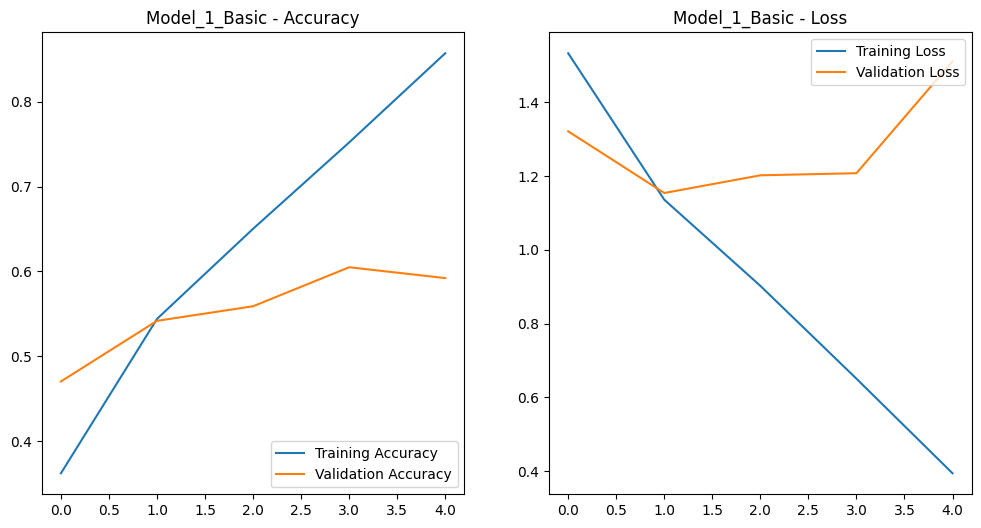

Evaluating Model_1_Basic...
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.5790 - loss: 1.4766
Model_1_Basic Test Accuracy: 57.90%


2025-12-16 19:50:39.123000: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


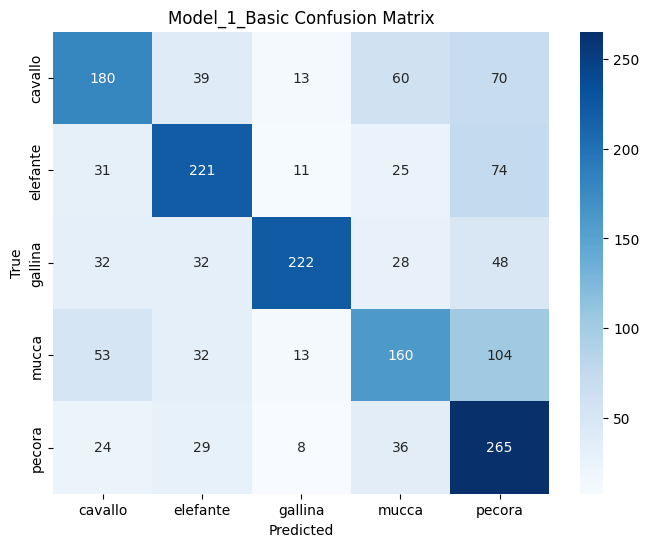

              precision    recall  f1-score   support

     cavallo       0.56      0.50      0.53       362
    elefante       0.63      0.61      0.62       362
     gallina       0.83      0.61      0.71       362
       mucca       0.52      0.44      0.48       362
      pecora       0.47      0.73      0.57       362

    accuracy                           0.58      1810
   macro avg       0.60      0.58      0.58      1810
weighted avg       0.60      0.58      0.58      1810



In [6]:
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
plot_history(history1, "Model_1_Basic")
evaluate_model(model1, "Model_1_Basic")

## M2: CNN Compleja (BN + Dropout)

In [7]:
model2 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

/home/daviuk/Documentos/Estudios/UP/8vo Semestre/Sistemas Inteligentes/Trabajo_Final/venv/lib/python3.13/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,332,933 (81.38 MB)

 Trainable params: 21,331,461 (81.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/5
 55/113 ━━━━━━━━━━━━━━━━━━━━ 1:34 2s/step - accuracy: 0.3025 - loss: 2.4734

2025-12-16 19:52:50.149342: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.3607 - loss: 1.9430 - val_accuracy: 0.2028 - val_loss: 4.6336
Epoch 2/5
 56/113 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - accuracy: 0.4506 - loss: 1.5123

2025-12-16 19:55:28.877670: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.4824 - loss: 1.4305 - val_accuracy: 0.2166 - val_loss: 4.1495
Epoch 3/5
 81/113 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5394 - loss: 1.2773

2025-12-16 19:59:47.984302: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.5549 - loss: 1.2375 - val_accuracy: 0.2936 - val_loss: 3.8047
Epoch 4/5
 54/113 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - accuracy: 0.5681 - loss: 1.1956

2025-12-16 20:02:10.353900: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.5768 - loss: 1.1594 - val_accuracy: 0.4399 - val_loss: 1.8685
Epoch 5/5
 58/113 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.6272 - loss: 1.0447

2025-12-16 20:05:48.167364: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6495 - loss: 0.9520 - val_accuracy: 0.4255 - val_loss: 1.8974


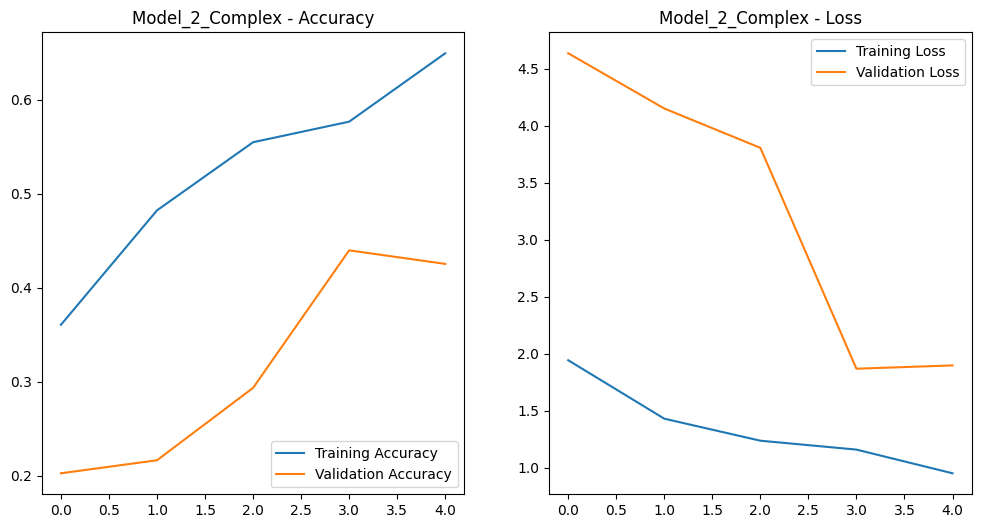

Evaluating Model_2_Complex...
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 251ms/step - accuracy: 0.4177 - loss: 1.9496
Model_2_Complex Test Accuracy: 41.77%


2025-12-16 20:07:45.092609: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


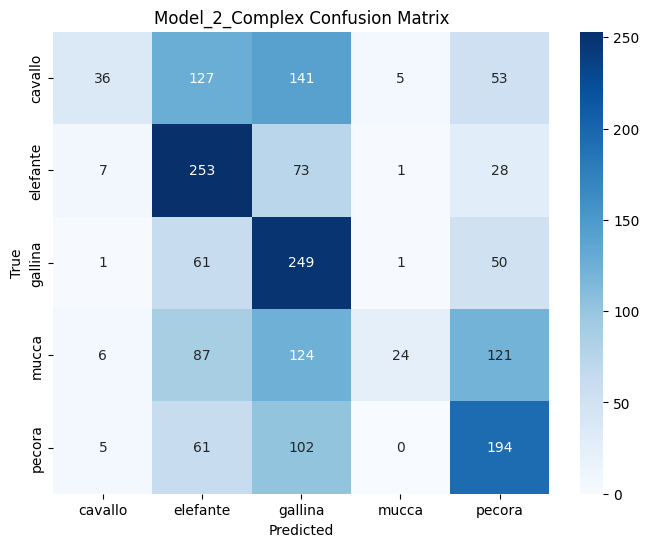

              precision    recall  f1-score   support

     cavallo       0.65      0.10      0.17       362
    elefante       0.43      0.70      0.53       362
     gallina       0.36      0.69      0.47       362
       mucca       0.77      0.07      0.12       362
      pecora       0.43      0.54      0.48       362

    accuracy                           0.42      1810
   macro avg       0.53      0.42      0.36      1810
weighted avg       0.53      0.42      0.36      1810



In [8]:
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
plot_history(history2, "Model_2_Complex")
evaluate_model(model2, "Model_2_Complex")

## M3: Data Augmentation

In [9]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

model3 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    data_augmentation,
    
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

/home/daviuk/Documentos/Estudios/UP/8vo Semestre/Sistemas Inteligentes/Trabajo_Final/venv/lib/python3.13/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    44,859,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,884,293 (171.22 MB)

 Trainable params: 44,883,077 (171.22 MB)

 Non-trainable params: 1,216 (4.75 KB)

Epoch 1/5
 67/113 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.2620 - loss: 2.8238

2025-12-16 20:10:15.503692: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.2932 - loss: 2.1820 - val_accuracy: 0.2039 - val_loss: 11.8773
Epoch 2/5
 62/113 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - accuracy: 0.3089 - loss: 1.8736

2025-12-16 20:12:52.020584: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.3347 - loss: 1.7852 - val_accuracy: 0.2011 - val_loss: 21.5426
Epoch 3/5
 90/113 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3389 - loss: 1.7633

2025-12-16 20:16:55.304930: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.3604 - loss: 1.6996 - val_accuracy: 0.2172 - val_loss: 11.2369
Epoch 4/5
 65/113 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.3456 - loss: 1.6608 

2025-12-16 20:19:35.675906: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.3765 - loss: 1.5613 - val_accuracy: 0.2687 - val_loss: 4.5849
Epoch 5/5
 57/113 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.3765 - loss: 1.5379

2025-12-16 20:22:51.325477: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


113/113 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.3986 - loss: 1.4835 - val_accuracy: 0.3114 - val_loss: 3.0874


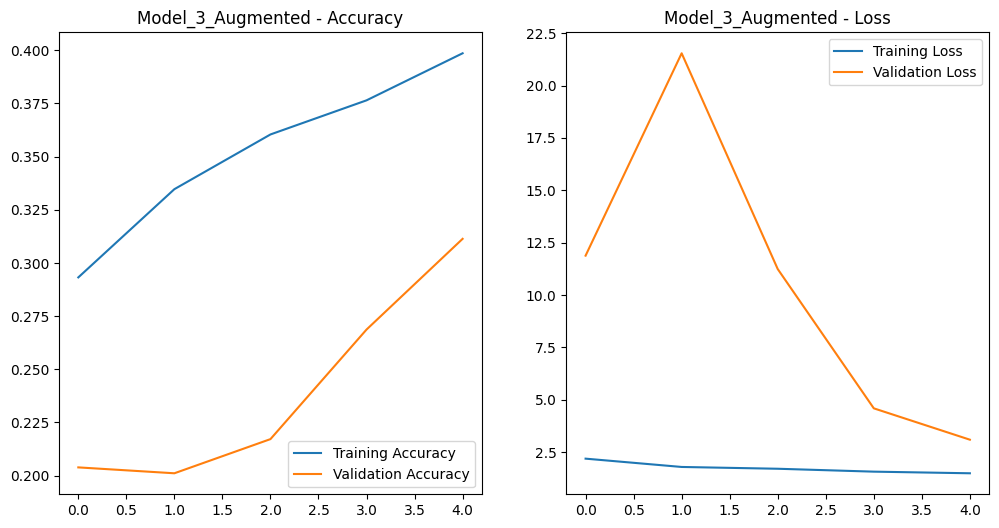

Evaluating Model_3_Augmented...
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.3017 - loss: 3.0909
Model_3_Augmented Test Accuracy: 30.17%


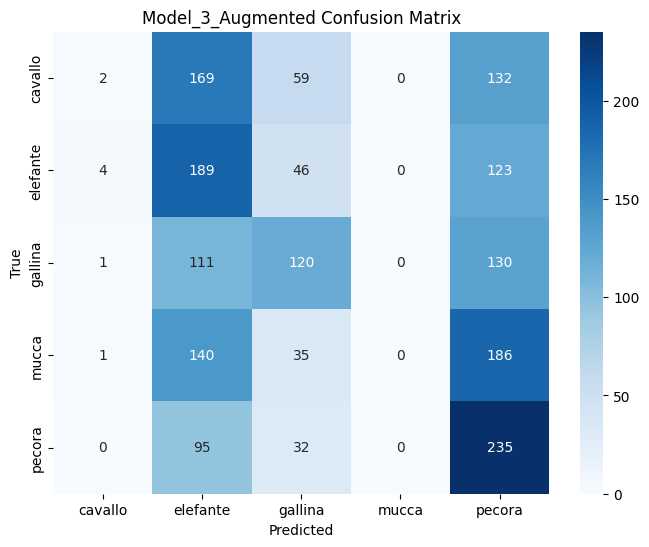

              precision    recall  f1-score   support

     cavallo       0.25      0.01      0.01       362
    elefante       0.27      0.52      0.35       362
     gallina       0.41      0.33      0.37       362
       mucca       0.00      0.00      0.00       362
      pecora       0.29      0.65      0.40       362

    accuracy                           0.30      1810
   macro avg       0.24      0.30      0.23      1810
weighted avg       0.24      0.30      0.23      1810



/home/daviuk/Documentos/Estudios/UP/8vo Semestre/Sistemas Inteligentes/Trabajo_Final/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daviuk/Documentos/Estudios/UP/8vo Semestre/Sistemas Inteligentes/Trabajo_Final/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/daviuk/Documentos/Estudios/UP/8vo Semestre/Sistemas Inteligentes/Trabajo_Final/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill

: 

In [ ]:
history3 = model3.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
plot_history(history3, "Model_3_Augmented")
evaluate_model(model3, "Model_3_Augmented")